In [1]:
%reload_ext autoreload
%autoreload 2
import os
import sys
sys.path.append('..')
import warnings
warnings.filterwarnings('ignore')

import csv
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

from src.document_preprocessor import RegexTokenizer
from src.indexing import BasicInvertedIndex, Indexer, IndexType
from src.ranker import BM25, Ranker
from src.relevance import run_relevance_tests

In [2]:
dataset_path = '../data/processed_articles_dedup_nsfwtags_sarcasm.csv'
multiwords_path = '../data/multiword_expressions.txt'
stopwords_path = '../data/stopwords_updated.txt'

relevance_train_path = '../data/relevance_train.csv'
relevance_test_path = '../data/relevance_test.csv'

In [3]:
from src.utils import load_txt

mwes = load_txt(multiwords_path)
stopwords = load_txt(stopwords_path)

In [4]:
preprocessor = RegexTokenizer("\w+(?:-\w+)*(?:'[^stmrvld]\w*)*", lowercase=True)
preprocessor_mwe = RegexTokenizer("\w+(?:-\w+)*(?:'[^stmrvld]\w*)*", lowercase=True, multiword_expressions=mwes)

# Index 

In [5]:
from src.indexing import Indexer, IndexType

In [6]:
index = Indexer.create_index(
    index_type=IndexType.BasicInvertedIndex, dataset_path=dataset_path, document_preprocessor=preprocessor, 
    stopwords=stopwords, minimum_word_frequency=0, text_key="body", id_key="docid"
)
index.save('output/index')

35292it [00:08, 4389.57it/s]


In [7]:
from src.indexing import Indexer, IndexType

index_mwe = Indexer.create_index(
    index_type=IndexType.BasicInvertedIndex, dataset_path=dataset_path, document_preprocessor=preprocessor_mwe, 
    stopwords=stopwords, minimum_word_frequency=0, text_key="body", id_key="docid"
)
index_mwe.save('output/index')

35292it [00:12, 2810.96it/s]


# Baselines

## No MWE

In [8]:
from src.ranker import Random, Ranker

random_scorer = Random(index)
random_ranker = Ranker(index, preprocessor, stopwords, random_scorer)

metrics_random = run_relevance_tests("../data/relevance_test.csv", ranker=random_ranker, encoding="utf-8-sig")
metrics_random['map'], metrics_random['ndcg']

(0.0, 0.0025518123461001855)

In [9]:
from src.ranker import TF_IDF, Ranker

tfidf_scorer = TF_IDF(index)
tfidf_ranker = Ranker(index, preprocessor, stopwords, tfidf_scorer)

metrics_tfidf = run_relevance_tests("../data/relevance_test.csv", ranker=tfidf_ranker, encoding="utf-8-sig")
metrics_tfidf['map'], metrics_tfidf['ndcg']

(0.24098901098901096, 0.5555199402545172)

In [10]:
from src.ranker import BM25, Ranker

bm25_scorer = BM25(index)
bm25_ranker = Ranker(index, preprocessor, stopwords, bm25_scorer)

metrics_bm25 = run_relevance_tests("../data/relevance_test.csv", ranker=bm25_ranker, encoding="utf-8-sig")
metrics_bm25['map'], metrics_bm25['ndcg']

(0.3393813593813594, 0.5792890913146169)

## MWE

In [11]:
# TF-IDF With preprocessor_mwe and index_mwe
from src.ranker import TF_IDF, Ranker

tfidf_scorer_mwe = TF_IDF(index_mwe)
tfidf_ranker_mwe = Ranker(index_mwe, preprocessor_mwe, stopwords, tfidf_scorer_mwe)

metrics_tfidf_mwe = run_relevance_tests("../data/relevance_test.csv", ranker=tfidf_ranker_mwe, encoding="utf-8-sig")
metrics_tfidf_mwe['map'], metrics_tfidf_mwe['ndcg']

(0.2512931166056166, 0.5491434029276523)

In [12]:
# BM25 With preprocessor_mwe and index_mwe
from src.ranker import BM25, Ranker

bm25_scorer_mwe = BM25(index_mwe)
bm25_ranker_mwe = Ranker(index_mwe, preprocessor_mwe, stopwords, bm25_scorer_mwe)

metrics_bm25_mwe = run_relevance_tests("../data/relevance_test.csv", ranker=bm25_ranker_mwe, encoding="utf-8-sig")
metrics_bm25_mwe['map'], metrics_bm25_mwe['ndcg']

(0.3372589794464794, 0.572555133279352)

# L2R

In [13]:
# Create title index
index_title = Indexer.create_index(
    index_type=IndexType.BasicInvertedIndex, dataset_path=dataset_path, document_preprocessor=preprocessor, 
    stopwords=stopwords, minimum_word_frequency=0, text_key="headline", id_key="docid"
)
index_title.save('output/index_title')

35292it [00:01, 23378.18it/s]


In [14]:
from src.l2r import L2RFeatureExtractor

fe = L2RFeatureExtractor(index, index_title, preprocessor, stopwords)

In [15]:
from src.l2r import L2RRanker

## BM25 Ranker

In [16]:
# L2R with BM25 ranker
bm25_scorer = BM25(index)
bm25_ranker = Ranker(index, preprocessor, stopwords, bm25_scorer)

l2r_ranker = L2RRanker(index, index_title, preprocessor, stopwords, bm25_ranker, fe)
l2r_ranker.train(relevance_train_path)

metrics_l2r = run_relevance_tests(relevance_test_path, ranker=l2r_ranker, encoding="utf-8-sig")
metrics_l2r['map'], metrics_l2r['ndcg']

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001227 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1404
[LightGBM] [Info] Number of data points in the train set: 1907, number of used features: 10


(0.1923878205128205, 0.42867017610817604)

In [17]:
feature_names = ["doc_length", "title_length", "query_length", 
                 "tf_doc", "tf_idf_doc", "tf_title", "tf_idf_title", 
                 "bm25_doc", "pivoted_norm_doc", "sarcasm_score"]

feature_importances = pd.DataFrame({
    "feature": feature_names,
    "importance": l2r_ranker.model.model.feature_importances_
}).sort_values("importance", ascending=False)

feature_importances.head(10)

,feature,importance
8,pivoted_norm_doc,1314.784666
6,tf_idf_title,760.231893
9,sarcasm_score,332.061319
4,tf_idf_doc,314.893411
1,title_length,188.167881
0,doc_length,155.234588
7,bm25_doc,128.718271
2,query_length,81.747021
5,tf_title,73.645780
3,tf_doc,47.383520


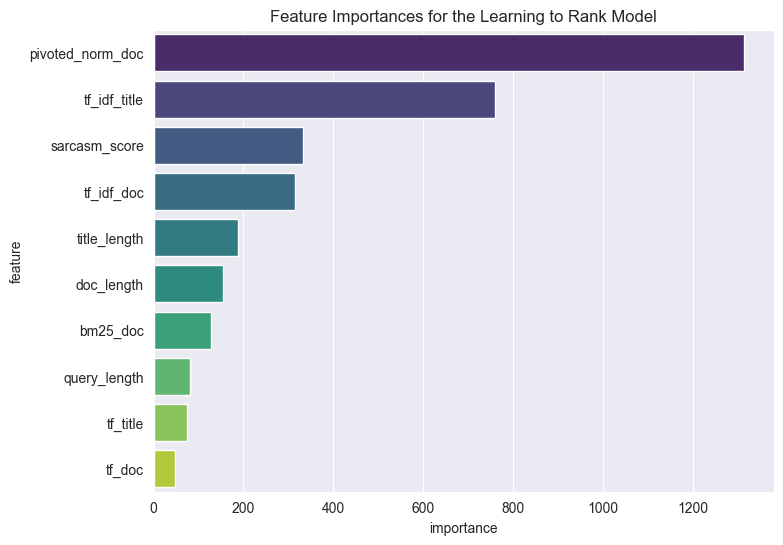

In [19]:
sns.set_style("darkgrid")
plt.figure(figsize=(8, 6))
sns.barplot(data=feature_importances, y="feature", x="importance", palette="viridis")
plt.title("Feature Importances for the Learning to Rank Model")
plt.show()

## VectorRanker

In [26]:
embeddings_path = '../data/body_embeddings.npy'
encoded_docs = np.load(embeddings_path)

len(index.document_metadata.keys()), encoded_docs.shape

(35279, (35279, 384))

In [27]:
# L2R with vector ranker
from src.vector_ranker import VectorRanker

vector_ranker = VectorRanker('sentence-transformers/msmarco-MiniLM-L12-cos-v5',
                             encoded_docs, list(index.document_metadata.keys()))

l2r_vector_ranker = L2RRanker(index, index_title, preprocessor, stopwords, vector_ranker, fe)
l2r_vector_ranker.train(relevance_train_path)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000149 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1404
[LightGBM] [Info] Number of data points in the train set: 1907, number of used features: 10


In [28]:
metrics_l2r_vector = run_relevance_tests(relevance_test_path, ranker=l2r_vector_ranker, encoding="utf-8-sig")
metrics_l2r_vector['map'], metrics_l2r_vector['ndcg']

(0.12415038665038663, 0.2193864320821005)

# HybridRanker

In [29]:
# Load the model
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

class HybridRanker:
    def __init__(self, base_ranker: Ranker, raw_text_dict: dict, alpha: float = 0.5, rerank_top_k: int = 10):
        self.base_ranker = base_ranker
        self.raw_text_dict = raw_text_dict
        self.alpha = alpha
        self.rerank_top_k = rerank_top_k
        self.model = model  # Use the loaded model

    def query(self, query: str) -> list[tuple[int, float]]:
        # Get initial BM25 rankings
        bm25_results = self.base_ranker.query(query)

        # Only rerank top k documents
        top_k_results = bm25_results[:self.rerank_top_k]

        # Get query embedding
        query_embedding = self.model.encode(query, normalize_embeddings=True)

        # Calculate BERT scores for top k
        reranked_scores = []
        docs = [self.raw_text_dict[docid] for docid, _ in top_k_results]
        doc_embeddings = self.model.encode(docs)

        # Calculate similarities
        for i, (docid, bm25_score) in enumerate(top_k_results):
            # Compute cosine similarity
            bert_score = float(doc_embeddings[i] @ query_embedding)

            # Combine scores using alpha
            final_score = self.alpha * bm25_score + (1 - self.alpha) * bert_score
            reranked_scores.append((docid, final_score))

        # Sort by combined score
        reranked_scores.sort(key=lambda x: x[1], reverse=True)

        return reranked_scores + bm25_results[self.rerank_top_k:]

# Load raw text for documents
raw_text_dict = {}
with open(dataset_path, 'r', encoding='utf-8') as f:
    reader = csv.DictReader(f)
    for row in reader:
        raw_text_dict[int(row['docid'])] = row['body']

In [30]:
# Create hybrid ranker
bm25_scorer = BM25(index)
bm25_ranker = Ranker(index, preprocessor, stopwords, bm25_scorer)

hybrid_ranker = HybridRanker(
    base_ranker=bm25_ranker,
    raw_text_dict=raw_text_dict,
    alpha=0.3,
    rerank_top_k=10
)

# Run evaluation
metrics_hybrid = run_relevance_tests("../data/relevance_test.csv", ranker=hybrid_ranker)
metrics_hybrid['map'], metrics_hybrid['ndcg']

(0.3347008547008547, 0.5845597217396821)

# Combine all metrics

In [31]:
metrics = {
    'Random': metrics_random,
    'TF-IDF': metrics_tfidf,
    'BM25': metrics_bm25,
    'TF-IDF (MWE)': metrics_tfidf_mwe,
    'BM25 (MWE)': metrics_bm25_mwe,
    'L2R (BM25)': metrics_l2r,
    'L2R (VectorRanker)': metrics_l2r_vector,
    'HybridRanker': metrics_hybrid
}

metrics_df = []
for ranker, metrics in metrics.items():
    metrics_df.append({
        "ranker": ranker, "metric": "MAP@10", 
        "mean_score": metrics["map"], "scores": metrics["map_list"]
    })
    metrics_df.append({
        "ranker": ranker, "metric": "NDCG@10", 
        "mean_score": metrics["ndcg"], "scores": metrics["ndcg_list"]
    })
    

metrics_df = pd.DataFrame(metrics_df)
metrics_df_long = metrics_df.drop("mean_score", axis=1).explode("scores")

metrics_df_long.to_csv("output/final_metrics.csv", index=False)

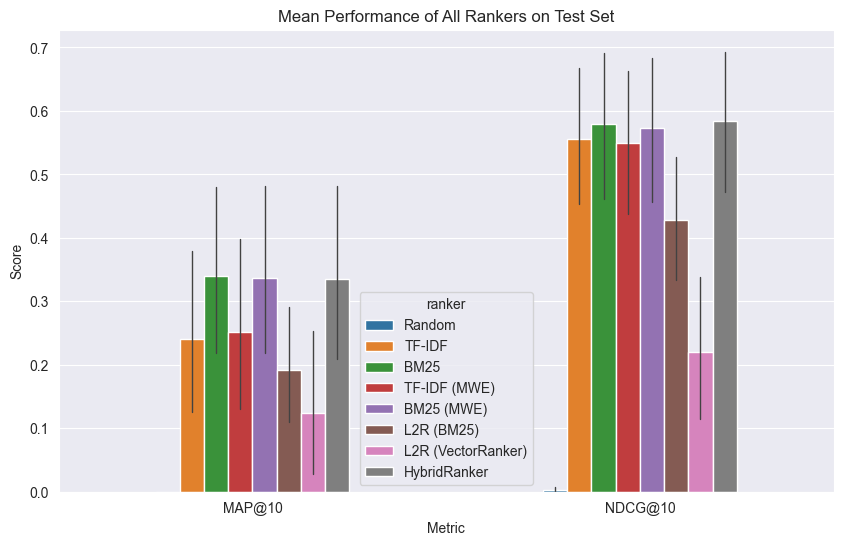

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(data=metrics_df_long, x="metric", y="scores", hue="ranker", 
            estimator='mean', errorbar=('ci', 95), width=0.5, errwidth=1)

plt.title("Mean Performance of All Rankers on Test Set")
# plt.legend(bbox_to_anchor=(1,1))
plt.xlabel("Metric")
plt.ylabel("Score")
plt.show()

In [43]:
metrics_df.pivot(index="ranker", columns="metric", values="mean_score")

metric,MAP@10,NDCG@10
ranker,,
BM25,0.339381,0.579289
BM25 (MWE),0.337259,0.572555
HybridRanker,0.334701,0.584560
L2R (BM25),0.192388,0.428670
L2R (VectorRanker),0.124150,0.219386
Random,0.000000,0.002552
TF-IDF,0.240989,0.555520
TF-IDF (MWE),0.251293,0.549143


In [36]:
with open('output/final_metrics.tex', 'w') as file_out:
    file_out.write(metrics_df.pivot(index="ranker", columns="metric", values="mean_score").to_latex(float_format='%0.2f'))